### Librairies import

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from pathlib import Path
import cv2
from tqdm import tqdm

from scipy import ndimage as ndi
from skimage.segmentation import watershed, felzenszwalb
from skimage.filters import sobel
from skimage.filters import rank
from skimage.morphology import disk
import sklearn.metrics

### Datasets import

In [2]:
from utils import get_data, plot_slice_seg, rand_index_dataset, prediction_to_df

In [5]:
X_train, X_test, y_train = get_data()

#### X_train collected ####
#### X_test collected ####
#### y_train collected ####


In [6]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {X_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {y_train.shape}")

X_train shape: (1000, 512, 512)
Y_train shape: (1000, 262144)


### Data display

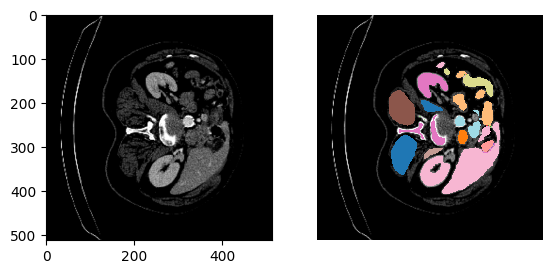

In [7]:
plot_slice_seg(X_train[0], y_train.iloc[0].values.reshape((512,512)))

### Baseline - Watershed model 

In [8]:
def compute_baseline_one_sample(data_slice):
    edges = sobel(data_slice)
    denoised = rank.median(data_slice, disk(2))
    markers = rank.gradient(denoised, disk(5)) < 20
    markers = ndi.label(markers)[0]
    label_predicted = watershed(edges, markers=markers, compactness=0.0001)
    return label_predicted

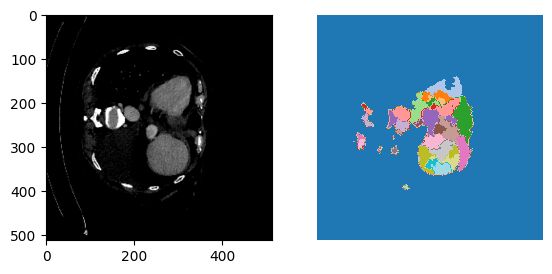

In [9]:
plot_slice_seg(X_train[2], compute_baseline_one_sample(X_train[2]))

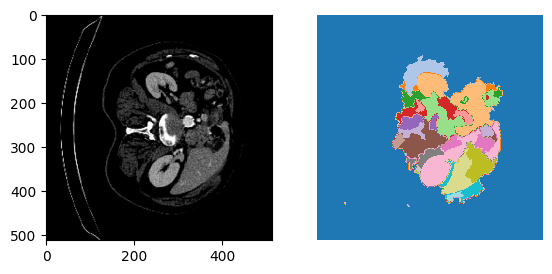

In [10]:
plot_slice_seg(X_train[0], compute_baseline_one_sample(X_train[0]))

### Baselin Performances 

In [11]:
# Compute the baseline on a whole dataset
def compute_baseline(dataset: np.array):
    labels_predicted_list = []
    for data_index in tqdm(range(len(dataset))):
        data_slice = dataset[data_index]
        label_predicted = compute_baseline_one_sample(data_slice)
        labels_predicted_list.append(label_predicted)
    return pd.DataFrame(np.stack(labels_predicted_list, axis=0).reshape((len(labels_predicted_list), -1)))

In [12]:
# Let's create a validation set first: the 200 first images of the train set 
data_val = X_train[:200]
labels_val = y_train.iloc[:200]

In [13]:
# Compute baseline on a few train data
labels_val_predicted_baseline = compute_baseline(data_val)

100%|███████████████████████████████████████████████████████████████████| 200/200 [00:44<00:00,  4.49it/s]


In [14]:
# Compute the metric on the validation set
rand_index_dataset(labels_val, labels_val_predicted_baseline.sample(200))
# We get => 0.27 (0.270633377755745); Not so bad, but room for improvements!
# Let's see if you can do better!

0.15828534434693753